# 定义股市数据类
### 方便数据获取，设置数据获取类
### 调用tushare金融数据API

In [1]:
import tushare as ts
import pandas as pd

class StockData(object):
    def __init__(self):
        self.pro = ts.pro_api('264f9e8a490cc3f2fa69cd654442ba812b45dd5680e706ce6988d818')

    def get_data(self,code, start='19900101', end='20190901'):
        stock_code = self.tran_code(code)
        return self.pro.query('daily', ts_code=stock_code, start_date=start, end_date=end)

    def tran_code(self,code):
        if code[0:1] == '6':
            return code + '.SH'
        else:
            return code + '.SZ'

## 获取数据
### 这里以 贵州茅台（600519）为例

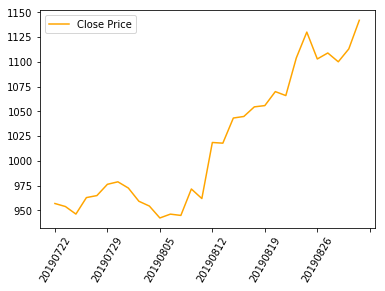

(4000, 12)


,index,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
3995,4,600519.SH,20190826,1113.0,1128.00,1096.68,1102.95,1130.10,-27.15,-2.4024,48497.89,5382792.365
3996,3,600519.SH,20190827,1117.0,1131.31,1109.00,1109.00,1102.95,6.05,0.5485,52164.21,5830617.878
3997,2,600519.SH,20190828,1109.0,1123.19,1083.01,1100.11,1109.00,-8.89,-0.8016,47009.67,5169778.985
3998,1,600519.SH,20190829,1105.0,1118.18,1092.50,1113.10,1100.11,12.99,1.1808,29330.42,3247704.307
3999,0,600519.SH,20190830,1125.0,1146.00,1123.00,1142.00,1113.10,28.90,2.5964,44890.77,5093877.152


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
def plot_stock(stock_data):
    temp_data = stock_data[['close','high','low','trade_date']]
    temp_data = temp_data.iloc[-30:]
    temp_data.set_index(['trade_date'], inplace=True)
    plt.plot(temp_data['close'],color='orange', label='Close Price')
    ax=plt.gca()
    x_major_locator=MultipleLocator(5)
    ax.xaxis.set_major_locator(x_major_locator)
    plt.xticks(rotation=60)
    plt.legend(loc='best')
    plt.show()

stock = StockData()
data = stock.get_data("600519")

# 从
data_test = stock.get_data("600519", start = '20190901',end = '20191201')
# 按照时间进行排序
data.sort_values("trade_date", inplace=True)
data = data.reset_index()
plot_stock(data)
print(data.shape)
data.tail()

### 使用数据分析的方法分析数据

#### 归一化处理

但从数据上来看，后两项数据（成交量和成交额）数量级和前6项数据差距太大

#### 分别采用了三种不同的归一化：

1、以 __close__ 的为标准，参照 __close__ 的 _max_ 和 _min_ 进行归一

2、直接用（-1，1）进行归一

3、采用sklearn的标准归一化进行归一

实践下来采用标准归一化的效果最好

(4000, 9)


Text(0, 0.5, 'feature magnitude')

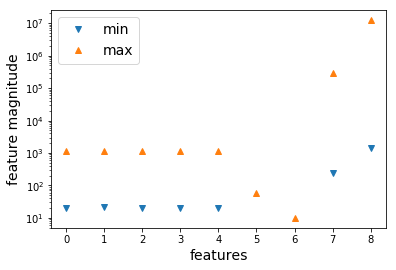

In [3]:
from sklearn import preprocessing as process
# 在数据分析之前先对所有的数据进行分析
# 后两项特征的数量级远大于其他项

X = data.loc[:,'open':'amount']
# X = data.loc[:,'close':'vol']
# X = X.drop(columns = ['pct_chg','pre_close'])
X = X.values
# y = data["close"].values
print(X.shape)

plt.plot(X.min(axis=0),'v',label='min')
plt.plot(X.max(axis=0),'^',label='max')
plt.yscale('log')
plt.legend(loc='best', fontsize = 14)
plt.xlabel('features', fontsize = 14)
plt.ylabel('feature magnitude', fontsize = 14)

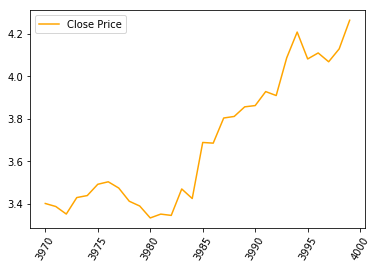

(4000, 9) (4000,)


In [4]:
# 训练集数据处理
# _max = data['close'].max()
# _min = data['close'].min()
# scaler = process.MinMaxScaler(feature_range=(_min, _max))
# scaler = process.MinMaxScaler(feature_range=(-1, 1))
scaler = process.StandardScaler()
scaler.fit(X)
X_scalerd = scaler.transform(X)
y = pd.DataFrame(X_scalerd)[3].values

temp_data = pd.DataFrame(X_scalerd)
temp_data = temp_data.iloc[-30:]

plt.plot(temp_data[3],color='orange', label='Close Price')
ax=plt.gca()
x_major_locator=MultipleLocator(5)
ax.xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=60)
plt.legend(loc='best')
plt.show()

print(X_scalerd.shape, y.shape)

### 利用热点图查看相关性

发现大体上可以分成三个部分于是乎想用PCA的方法进行降维

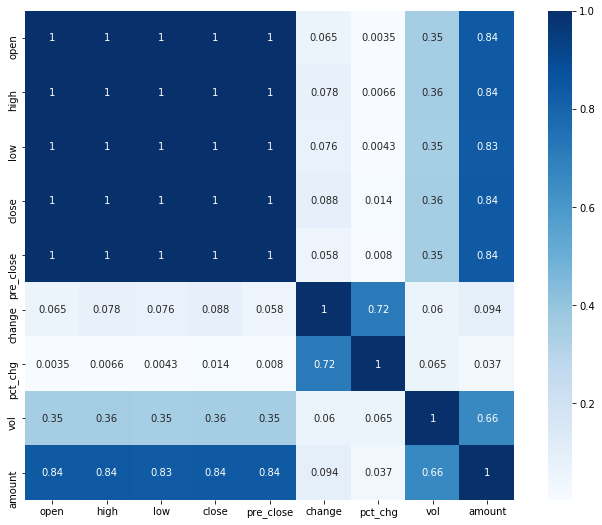

In [7]:
import seaborn as sns
def corr_heat(df):
    df = df.drop(columns = ['index'])
    dfData = abs(df.corr())
    plt.subplots(figsize=(12, 9)) # 设置画面大小
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    # plt.savefig ('./BluesStateRelation.png')
    plt.show()

corr_heat(data)

### 使用PCA的效果确实不好，遂放弃

In [8]:
from sklearn.decomposition import PCA
import numpy as np

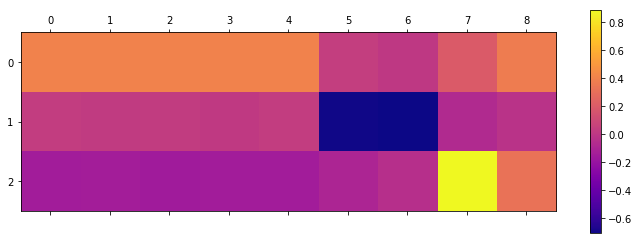

0.9564796431670302


In [25]:
# 看大体上可以分成3个部分
pca = PCA(n_components=3)

pca.fit(X_scalerd, y)

X_pca = pca.transform(X)
plt.matshow(pca.components_, cmap='plasma')
plt.colorbar()
plt.show()
print(np.sum(pca.explained_variance_ratio_))

# LSTM模型搭建
### 调用keras的LSTM模型

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras.layers import RepeatVector
import keras

Using TensorFlow backend.


## 先采用1-1的方式进行训练

In [7]:
# 用t天的数据预测t+1天的，所以把y前移
# X有一个会多出来，所以删掉X的最后一个和y的第一个
import numpy as np

# X_train = X_pca
X_train = pd.DataFrame(X_scalerd)[[3,5,7]].values

X_train = np.delete(X_train, -1, axis=0)
y_train = np.delete(y, [1])


X_train = X_train.reshape(X_train.shape[0],1, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0],1, 1)
print(X_train.shape, y_train.shape)

(3999, 1, 3) (3999, 1, 1)


In [54]:
model = Sequential()

model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

model.add(Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
 
adam = keras.optimizers.Adam(decay=0.2)
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 128)            67584     
_________________________________________________________________
dense_16 (Dense)             (None, 1, 16)             2064      
_________________________________________________________________
dense_17 (Dense)             (None, 1, 1)              17        
Total params: 69,665
Trainable params: 69,665
Non-trainable params: 0
_________________________________________________________________


(3999, 1, 3) (3999, 1, 1)
Epoch 1/100
 - 1s - loss: 0.6435 - accuracy: 0.0000e+00
Epoch 2/100
 - 0s - loss: 0.3105 - accuracy: 0.0000e+00
Epoch 3/100
 - 0s - loss: 0.1486 - accuracy: 0.0000e+00
Epoch 4/100
 - 0s - loss: 0.1039 - accuracy: 0.0000e+00
Epoch 5/100
 - 0s - loss: 0.1012 - accuracy: 0.0000e+00
Epoch 6/100
 - 0s - loss: 0.0838 - accuracy: 0.0000e+00
Epoch 7/100
 - 0s - loss: 0.0862 - accuracy: 0.0000e+00
Epoch 8/100
 - 0s - loss: 0.0520 - accuracy: 0.0000e+00
Epoch 9/100
 - 0s - loss: 0.0770 - accuracy: 0.0000e+00
Epoch 10/100
 - 0s - loss: 0.0533 - accuracy: 0.0000e+00
Epoch 11/100
 - 0s - loss: 0.0721 - accuracy: 0.0000e+00
Epoch 12/100
 - 0s - loss: 0.0494 - accuracy: 0.0000e+00
Epoch 13/100
 - 0s - loss: 0.0684 - accuracy: 0.0000e+00
Epoch 14/100
 - 0s - loss: 0.0509 - accuracy: 0.0000e+00
Epoch 15/100
 - 0s - loss: 0.0630 - accuracy: 0.0000e+00
Epoch 16/100
 - 0s - loss: 0.0450 - accuracy: 0.0000e+00
Epoch 17/100
 - 0s - loss: 0.0548 - accuracy: 0.0000e+00
Epoch 18/100
 

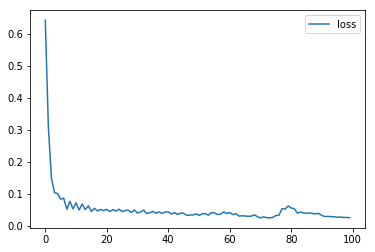

In [55]:
# 训练模型
print(X_train.shape, y_train.shape)
history = model.fit(X_train, y_train, epochs=100, verbose=2, shuffle=False)

model.save("1-1.h5")

# plot history
plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show()

In [14]:
# 自己定义了一个对于涨跌是否正确的计算方法

def cal_ac_rate(ori, pre):
    ori_r = []
    pre_r = []
    ac = 0
    if ori.shape[0] != pre.shape[0]:
        return 0
    else:
        for i in range(0, ori.shape[0]-1):
            if ori[i]-ori[i+1] < 0 :
                ori_r.append(1)
            if ori[i]-ori[i+1] > 0 :
                ori_r.append(-1)
            if ori[i]-ori[i+1] == 0 :
                ori_r.append(0)
                
            if pre[i]-pre[i+1] < 0 :
                pre_r.append(1)
            if pre[i]-pre[i+1] > 0 :
                pre_r.append(-1)
            if pre[i]-pre[i+1] == 0 :
                pre_r.append(0)
        for i in range(0, len(ori_r)-1):
            if ori_r[i] == pre_r[i]:
                ac += 1
        
        return ac,len(ori_r)

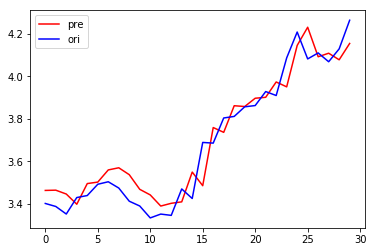

(1989, 3998)

In [73]:
# model = load_model('1-1.h5')

predictes_stock_price = model.predict(X_train)

predictes_stock_price = predictes_stock_price.reshape(predictes_stock_price.shape[0])
y_train = y_train.reshape(y_train.shape[0])

plt.plot(predictes_stock_price[-30:], label='pre', color='red')
plt.plot(y_train[-30:], label='ori', color='blue')
plt.legend()
plt.show()

cal_ac_rate(y_train, predictes_stock_price)

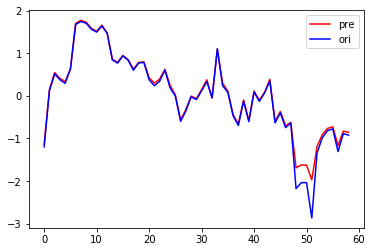

(56, 58)

In [67]:
# 测试集数据处理
X_test = data_test.loc[:,'close':'vol']
X_test = X_test.drop(columns = ['change','pct_chg'])
X_test = X_test.values

scaler = process.StandardScaler()
scaler.fit(X_test)
X_test_scalerd = scaler.transform(X_test)
y_test = pd.DataFrame(X_test_scalerd)[0].values

X_test_scalerd = X_test_scalerd.reshape(X_test_scalerd.shape[0],1, X_test_scalerd.shape[1])

pre_test = model.predict(X_test_scalerd)

pre_test = pre_test.reshape(pre_test.shape[0])

plt.plot(pre_test, label='pre', color='red')
plt.plot(y_test, label='ori', color='blue')
plt.legend()
plt.show()

cal_ac_rate(y_test, pre_test)

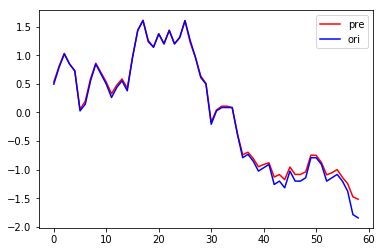

(53, 58)

In [72]:
# 用工商银行测试贵州茅台的模型

data_test_2 = stock.get_data("601398", start = '20190901',end = '20191201')

X_test_2 = data_test_2.loc[:,'close':'vol']
X_test_2 = X_test_2.drop(columns = ['pre_close','pct_chg'])
X_test_2 = X_test_2.values

scaler = process.StandardScaler()
scaler.fit(X_test_2)
X_test_scalerd_2 = scaler.transform(X_test_2)
y_test_2 = pd.DataFrame(X_test_scalerd_2)[0].values

X_test_scalerd_2 = X_test_scalerd_2.reshape(X_test_scalerd_2.shape[0],1, X_test_scalerd_2.shape[1])

pre_test_2 = model.predict(X_test_scalerd_2)

pre_test_2 = pre_test_2.reshape(pre_test_2.shape[0])

plt.plot(pre_test_2, label='pre', color='red')
plt.plot(y_test_2, label='ori', color='blue')
plt.legend()
plt.show()

cal_ac_rate(y_test_2, pre_test_2)

# 采用21-3的方式进行训练

In [8]:
# 把数据处理成（x,21,z）的三维状态，把步长包含进来
def deal_data_set(ort_datasets):
    X_train_B = []
    y_train_B = []
    ort_datasets = ort_datasets.reshape(ort_datasets.shape[0],ort_datasets.shape[2])
    need_num_x = 21
    need_num_y = 3
    #每need_num_x个数据为一组，作为测试数据，后need_num_y数据为标签
    for i in range(need_num_x, X_scalerd.shape[0]-need_num_y-1):
        X_train_B.append(ort_datasets[i-need_num_x: i])
        y_train_B.append(ort_datasets[i+1: i+need_num_y+1, 0])

    # 将数据转化为数组
    X_train_B = np.array(X_train_B)
    y_train_B = np.array(y_train_B)
    print(X_train_B.shape, y_train_B.shape)
    y_train_B = np.reshape(y_train_B, (y_train_B.shape[0],1, y_train_B.shape[1]))
    
    return X_train_B,y_train_B

X_train_B,y_train_B = deal_data_set(X_train)

(3975, 21, 3) (3975, 3)


In [9]:
model = Sequential()

model.add(LSTM(128, input_shape=(X_train_B.shape[1], X_train.shape[2])))
#model.add(Dropout(0.5))

model.add(RepeatVector(1))

model.add(Dense(16,kernel_initializer="uniform",activation='relu'))
model.add(Dense(3,kernel_initializer="uniform",activation='linear'))
 
adam = keras.optimizers.Adam(decay=0.5)
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67584     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 16)             2064      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 3)              51        
Total params: 69,699
Trainable params: 69,699
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train_B, y_train_B, epochs=100, verbose=2, shuffle=False)
model.save("21-3.h5")


Epoch 1/100
 - 2s - loss: 0.6075 - accuracy: 0.3109
Epoch 2/100
 - 2s - loss: 0.2758 - accuracy: 0.3042
Epoch 3/100
 - 2s - loss: 0.6014 - accuracy: 0.3273
Epoch 4/100
 - 2s - loss: 0.4405 - accuracy: 0.3406
Epoch 5/100
 - 2s - loss: 0.4591 - accuracy: 0.3308
Epoch 6/100
 - 2s - loss: 0.4561 - accuracy: 0.3049
Epoch 7/100
 - 2s - loss: 0.5901 - accuracy: 0.3084
Epoch 8/100
 - 2s - loss: 0.6231 - accuracy: 0.2760
Epoch 9/100
 - 2s - loss: 0.6231 - accuracy: 0.3177
Epoch 10/100
 - 2s - loss: 0.6028 - accuracy: 0.3618
Epoch 11/100
 - 2s - loss: 0.5895 - accuracy: 0.3220
Epoch 12/100
 - 2s - loss: 0.5634 - accuracy: 0.3109
Epoch 13/100
 - 2s - loss: 0.3444 - accuracy: 0.3042
Epoch 14/100
 - 2s - loss: 0.3600 - accuracy: 0.2714
Epoch 15/100
 - 2s - loss: 0.3707 - accuracy: 0.2921
Epoch 16/100
 - 2s - loss: 0.4140 - accuracy: 0.3026
Epoch 17/100
 - 2s - loss: 0.3002 - accuracy: 0.3243
Epoch 18/100
 - 2s - loss: 0.2714 - accuracy: 0.3660
Epoch 19/100
 - 2s - loss: 0.2258 - accuracy: 0.3077
Ep

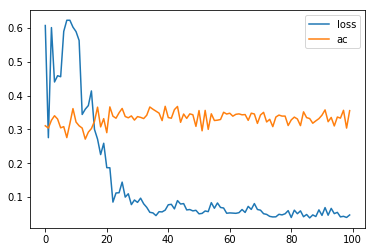

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='ac')
plt.legend()
plt.show()

In [12]:
# 直接上手测试

data_test_3 = stock.get_data("600519", start = '20190901',end = '20191206')

X_test_3 = data_test_3.loc[:,'close':'vol']
X_test_3 = X_test_3.drop(columns = ['pre_close','pct_chg'])
X_test_3 = X_test_3.values

scaler = process.StandardScaler()
scaler.fit(X_test_3)
X_test_scalerd_3 = scaler.transform(X_test_3)

X_test_3 = []
for i in range(21, X_test_scalerd_3.shape[0]-3):
    X_test_3.append(X_test_scalerd_3[i-21: i])

X_test_3 = np.array(X_test_3)
y_test_3 = X_test_scalerd_3[22:, 0]

# 预测
# model = load_model("21-5.h5")
pre_test_3 = model.predict(X_test_3)

pre_test_3 = pre_test_3.reshape(pre_test_3.shape[0],pre_test_3.shape[2])

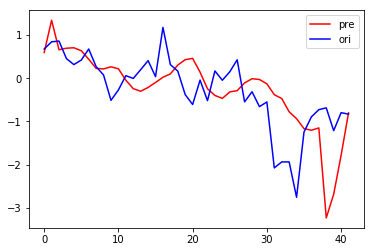

22 80 0.275


In [15]:
pre_test_3_2 = [0,0]
cor = 0
num_all = 0
for i in range(0, pre_test_3.shape[0]):
    pre_test_3_2[i] += pre_test_3[i,0]
    pre_test_3_2[i+1] += pre_test_3[i,1]
    pre_test_3_2.append(pre_test_3[i,2])
    
    y_test_3_2 = [y_test_3[i],y_test_3[i+1],y_test_3[i+2]]
    y_test_3_2 = np.array(y_test_3_2)
    pre_test_3_2_2 = [pre_test_3[i,0],pre_test_3[i,1],pre_test_3[i,2]]
    pre_test_3_2_2 = np.array(pre_test_3_2_2)
    
    a,b = cal_ac_rate(y_test_3_2, pre_test_3_2_2)
    cor += a
    num_all += b 

for i in range(2,pre_test_3.shape[0]-2):
    pre_test_3_2[i] /= 3
    
pre_test_3_2 = np.array(pre_test_3_2)

plt.plot(pre_test_3_2, label='pre', color='red')
plt.plot(y_test_3, label='ori', color='blue')
plt.legend()
plt.show()

print(cor, num_all, cor/num_all)

# 总结：
## 股市有风险！投资需谨慎！